In [24]:
from dotenv import load_dotenv

load_dotenv()

True

In [25]:
# retrieve -> generate -> rewrite -> 문서 검증 
from langchain_chroma import Chroma 
from langchain_openai import OpenAIEmbeddings

embedding_function = OpenAIEmbeddings(model="text-embedding-3-large")

vector_store = Chroma(
    embedding_function=embedding_function,
    collection_name="income_tax_collection",
    persist_directory="./income_tax_collection"
)

retriever = vector_store.as_retriever(search_kwargs={"k": 3})

In [26]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph

class AgentState(TypedDict):
    query: str
    context: list
    answer: str

graph_builder = StateGraph(AgentState)

In [27]:
def retrieve(state: AgentState):
    query = state['query']
    docs = retriever.invoke(query)
    return {'context': docs}

In [28]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o")

In [29]:
from langchain_classic import hub
from langchain_core.output_parsers import StrOutputParser

generate_prompt = hub.pull("rlm/rag-prompt")
generate_llm = ChatOpenAI(model="gpt-4o", max_completion_tokens=100)
def generate(state: AgentState):
    context = state['context']
    query = state['query']
    rag_chain = generate_prompt | generate_llm | StrOutputParser()
    response = rag_chain.invoke({"question": query, "context": context})
    print(f'rewrite question == {response}')
    return {"answer": response}

In [30]:
from langchain_classic import hub
from typing import Literal 

doc_relevance_prompt = hub.pull("langchain-ai/rag-document-relevance")

def check_doc_relevance(state: AgentState) -> Literal['relevant', 'irrelevant']:
    query = state['query']
    context = state['context'] 
    print(f"context == {context}")
    doc_relevance_chain = doc_relevance_prompt | llm
    response = doc_relevance_chain.invoke({"question": query, "documents": context})
    print(f'doc relevance response: {response}')
    if response['Score'] == 1:
        return 'relevant'
    return 'irrelevant'

In [31]:
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser

rewrite_prompt = PromptTemplate.from_template("""사용자의 질문을 보고, 웹 검색에 용이하게 사용자의 질문을 수정해주세요. 
    질문: {query}
    """)

def rewrite(state: AgentState):
    query = state['query']
    rewrite_chain = rewrite_prompt | llm | StrOutputParser()

    response = rewrite_chain.invoke({"query": query})
    return {"query": response}

In [32]:
from langchain_community.tools import TavilySearchResults

tavily_search_tool = TavilySearchResults(
    max_results=3,
    search_depth="advanced",
    include_answer=True,
    include_raw_content=True,
    include_images=True,
)

def web_search(state: AgentState):
    query = state['query']
    results = tavily_search_tool.invoke(query)
    print(f'web search results: {results}')
    return {"context": results}

In [33]:
graph_builder.add_node('retrieve', retrieve)
graph_builder.add_node('generate', generate)
graph_builder.add_node('rewrite', rewrite)
graph_builder.add_node('web_search', web_search)

In [34]:
from langgraph.graph import START, END 

graph_builder.add_edge(START, 'retrieve')
graph_builder.add_conditional_edges(
    'retrieve',
    check_doc_relevance,
    {
        'relevant': 'generate',
        'irrelevant': 'rewrite'
    }
)

graph_builder.add_edge('rewrite', 'web_search')
graph_builder.add_edge('web_search', 'generate')
graph_builder.add_edge('generate', END)

In [35]:
graph = graph_builder.compile()

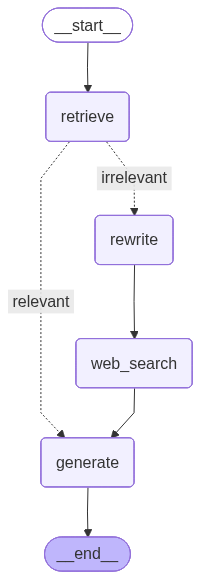

In [36]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [37]:
initial_state = {'query': '연봉 5천만원 거주자의 소득세는 얼마인가요?'}
graph.invoke(initial_state)

context == [Document(id='24c5d5c3-0fcc-4f37-b55e-450d1f7c551d', metadata={'source': './documents/income_tax.txt'}, page_content='② 제70조제1항, 제70조의2에 따른 제74조에 따라 차례로 할 것이 제70조제1항제2호에 따르며 서류를 제출하여야 한다는 경우에는 기준소득 중 거주자 본인이 된다(분산)과 제70조제2와 제74조에 따른 제료 및 제대법을 포함한다. 단, 차별제표청정인 그 업체를 남겨 제출한 경우로 그에 대하여 아니하다.<개정 2013. 1. 1.>\n  ③ 제80조에 따른 수익과 관련의 경우에는 기초공제 중 거주자 본인이 된다(분산)과 그에 관한 적지사항을 분명히 한다.\n[전문개정 2009. 12. 31.]\n[제목개정 2014. 1. 1.]\n제54조의2(공동사업에 대한 소득공제 등 특례) 제51조의3 또는 「조세특례제한법」에 따른 소득공제를 적용하거나 제59조의2에 따른 세액감면을 적용하는 경우 제54조제3항에 따라 공동사업자의 소득에 합산과세되는 특별세액거래의 지출․납입․투자 등의 금액이 있을 경우 주된 공동사업자의 소득에 합산과세되는 소득금액에 합산되어 주된 공동사업자의 합산과세세액은 공동사업소득액 또는 공동사업창출세액을 계산할 때 소득공제 또는 세액공제를 받을 수 있다. \n[개정 2014. 1. 1.]\n[전문개정 2009. 12. 31.]\n[제목개정 2014. 1. 1.]\n제2절 세액의 계산 <개정 2009. 12. 31.>\n제1관 세율 <개정 2009. 12. 31.>\n제55조(세율) 거주자의 종합소득에 대한 소득세는 해당 연도의 종합소득과세표준에 다음의 세율을 적용하여 계산한 금액(이하 "종합소득과세표준세액"이라 한다)을 그 세액으로 한다. <개정 2014. 1. 1., 2016. 12. 20., 2017. 12. 19., 2020. 12. 29., 2022. 12. 31.>\n종합소득\n┌───────────────┐\n

{'query': '연봉 5천만원 거주자의 소득세는 얼마인가요?',
 'context': [Document(id='24c5d5c3-0fcc-4f37-b55e-450d1f7c551d', metadata={'source': './documents/income_tax.txt'}, page_content='② 제70조제1항, 제70조의2에 따른 제74조에 따라 차례로 할 것이 제70조제1항제2호에 따르며 서류를 제출하여야 한다는 경우에는 기준소득 중 거주자 본인이 된다(분산)과 제70조제2와 제74조에 따른 제료 및 제대법을 포함한다. 단, 차별제표청정인 그 업체를 남겨 제출한 경우로 그에 대하여 아니하다.<개정 2013. 1. 1.>\n  ③ 제80조에 따른 수익과 관련의 경우에는 기초공제 중 거주자 본인이 된다(분산)과 그에 관한 적지사항을 분명히 한다.\n[전문개정 2009. 12. 31.]\n[제목개정 2014. 1. 1.]\n제54조의2(공동사업에 대한 소득공제 등 특례) 제51조의3 또는 「조세특례제한법」에 따른 소득공제를 적용하거나 제59조의2에 따른 세액감면을 적용하는 경우 제54조제3항에 따라 공동사업자의 소득에 합산과세되는 특별세액거래의 지출․납입․투자 등의 금액이 있을 경우 주된 공동사업자의 소득에 합산과세되는 소득금액에 합산되어 주된 공동사업자의 합산과세세액은 공동사업소득액 또는 공동사업창출세액을 계산할 때 소득공제 또는 세액공제를 받을 수 있다. \n[개정 2014. 1. 1.]\n[전문개정 2009. 12. 31.]\n[제목개정 2014. 1. 1.]\n제2절 세액의 계산 <개정 2009. 12. 31.>\n제1관 세율 <개정 2009. 12. 31.>\n제55조(세율) 거주자의 종합소득에 대한 소득세는 해당 연도의 종합소득과세표준에 다음의 세율을 적용하여 계산한 금액(이하 "종합소득과세표준세액"이라 한다)을 그 세액으로 한다. <개정 2014. 1. 1., 2016. 12. 20., 2017. 12. 19., 2020. 12. 29., 20

In [38]:
initial_state = {'query': '역삼역 맛집을 추천해주세요.'}
graph.invoke(initial_state)

context == [Document(id='dd060080-7ee7-4a6d-9665-017c97ddf33d', metadata={'source': './documents/income_tax.txt'}, page_content='1. ‘세무처리’에 따른 세무조정을 통합한 세무서\n2. ‘세무조정’에 따른 세무조정방식으로 세무거래명부부록에 등록한 공인회계사\n3. ‘세무처리’에 따른 세무조정 또는 변호사 세무거래명부부록에 등록한 변호사\n[전문개정 2009. 12. 31.]\n[2021. 11. 23. 법률 제18521호에 의하여 2018. 4. 26. 헌법재판소에서 헌법불합치 결정에 의한 조치를 개정하였다.]\n제070조(종합소득과세표준 확정신고) ③ 해당 과세기간에 병립과세 주택매도소득, 제273조제1항제27조 및 제127조제1항제6호나목의 소득이 있는 경우에도 제126항에 따른 “종합소득 과세표준확정신고서”라 한다.\n➄ 종합소득과세표준확정신고를 할 때에는 “신고서”의 다음 각 호의 서류를 첨부하여 납세자에게 제출하여야 한다. 이 경우 제160조제3항에 따른 복식부기의무자가 제630호에 따른 세무를 제출하지 아니하는 경우에는 종합소득 과세표준확정신고로 하지 아니하는 것으로 본다.<개정 2010. 12. 27. 2012. 1. 1. 2014. 1. 1.>\n1. 인적증명, 연구보고서, 주택보조금부록, 특별소득증명, 자녀세액공제, 연금계좌세액공제 및 특별세액에 대한 내용을 증명하는 서류로서 대통령령으로 정하는 것\n2. 종합소득액의 계산이 기초한 총수입금액의 계산에 필요한 서류로서 대통령령으로 정하는 것\n3. 사업소득금액 제160조 및 제161조의2에 따른 비치·기록할 장부의 증명서류에 의하여 계산하지 아니하는 경우에는 기획재정부로 정하는 재무제표·손익계산서와 부속서류, 현황재무제표(現況財務表) 및 대통령령으로 정하는 바에 따라 작성한 조정계산서. 다만, 제160조제1항에 따라 기상(基商)을 한 사업자의 경우에는 기획재정부로 정하는 간편장부소득금액을 계산서

{'query': '"역삼역 주변 인기 맛집 추천"',
 'context': [{'title': '역삼 맛집 Top100 - 다이닝코드',
   'url': 'https://www.diningcode.com/list.dc?query=%EC%97%AD%EC%82%BC',
   'content': '# 역삼 맛집 (1,770곳)\n\n역삼에서  \n인기있는 음식을 살펴보세요.\n\n역삼 음식 랭킹\n\n## 1. 대우부대찌개 역삼역\n\n87점\n\n4.1(62명)\n\n부대찌개미나리\n\n다코숨은맛집식사모임무료주차서민적인\n\n오늘 휴무\n\n"시원한 의정부식의 느낌과 진한 송탄식의 느낌을 잘 조화시켜 놓은 듯한 절묘한 부대찌개의 맛을 느낄수 있는 곳. 푸짐한 미나리로..."\n## 2. 돝고기506 역삼역\n\n86점\n\n4.3(38명)\n\n삼겹살숙성돼지고기\n\n다코숨은맛집술모임발렛파킹고급스러운\n\n영업 중\n\n"너무 맛있어요 특히 트리플 크림 볶음밥!!\n사악한 가격인것같지만 먹으면 이해되는 맛 또먹고 싶다고 생각되는 집"## 3. 신동궁 감자탕 역삼본점\n\n85점\n\n4.3(61명)\n\n감자탕뼈숯불구이\n\nvj특공대술모임무료주차서민적인\n\n영업 중\n\n"매운 걸 잘 못먹지만 다음날 아침을 걱정하면서도 가는 곳.\n뒤 끝이 길지 않은 매콤칼칼한 양념이 밥도둑 술도둑입니다.\n양도 푸..."## 4. 불이아 역삼점\n\n84점 [...] "평양냉면도 맛있고 겨울에 곰탕도 맛있는 집입니다. 평양냉면은 메밀함량을 선택할수도 있게 해뒀어요. 손만두도 큼지막하고 맛있습니..."## 19. 고갯마루 역삼\n\n79점\n\n4.1(15명)\n\n닭볶음탕\n\n식사모임무료주차서민적인예약필수\n\n오늘 휴무\n\n"역삼 맛집, 닭볶음탕 인생 맛집 중 하나에요!\n굳이굳이 역삼까지 가서 먹을만 합니다\n떡과 감자도 미리 추가하셔서 드시고 한국..."## 20. 대독장 역삼역\n\n79점\n\n4.2(16명)\n\n김치찌개계란후라이\n\n전참시혼밥무료주차서민